# Setting up environment

In [1]:
!pip install gymnasium stable-baselines3[extra] optuna

import functools
import os
from datetime import datetime

from stable_baselines3.common.monitor import Monitor
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output


  Using cached sqlalchemy-2.0.44-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (2.4 kB)
  Using cached greenlet-3.2.4-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 7.2 MB/s eta 0:00:00
Using cached sqlalchemy-2.0.44-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
Using cached pyyaml-6.0.3-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl (807 kB)
Using cached greenlet-3.2.4-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (607 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.1 MB/s eta 0:00:00


In [ ]:

# load environment
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv

from sixseven_env import SixSevenEnv

#env = make_vec_env(SixSevenEnv, n_envs=1)
env = SixSevenEnv()
env = Monitor(env, filename="monitor_results/monitor.csv", info_keywords=("win",))
env = DummyVecEnv([lambda: env])
#obs, _ = env.reset()
env.reset()
#env.step(env.action_space.sample())

array([[0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
        1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   ,
        0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   ,
      

# PPO Model

In [ ]:
import optuna
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

optuna.logging.set_verbosity(optuna.logging.WARNING)

def optimize_ppo(trial):
    env = DummyVecEnv([lambda: Monitor(SixSevenEnv())])

    # --- Suggest hyperparameters ---
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])

    # --- Create model ---
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        n_steps=1024,
        verbose=0,
    )

    # --- Train briefly (Optuna trials should be short!) ---
    for step in range(4):
        model.learn(1000, reset_num_timesteps=False)

        # Get recent rewards from ep_info_buffer
        if len(model.ep_info_buffer) > 0:
            mean_reward = sum([ep["r"] for ep in model.ep_info_buffer]) / len(model.ep_info_buffer)
        else:
            mean_reward = -9999

        # Report intermediate result
        trial.report(mean_reward, step)

        # Early stopping if trial is bad
        if trial.should_prune():
            raise optuna.TrialPruned()

    return mean_reward

In [ ]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1000)
study = optuna.create_study(direction="maximize", pruner=pruner)

study.optimize(optimize_ppo, n_trials=20)

/tmp/ipython-input-464610839.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-464610839.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipython-input-464610839.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipython-input-464610839.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0.

In [ ]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: 12.6378
  Params: 
    learning_rate: 3.1575559364088504e-05
    gamma: 0.9584662104553401
    batch_size: 64


In [ ]:
best_params = study.best_params

model = PPO(
    "MlpPolicy",   # simple feed-forward policy
    env,
    verbose=1,
    **best_params,
)

Using cpu device


In [ ]:
%%capture --no-display
model.learn(total_timesteps=100_000)

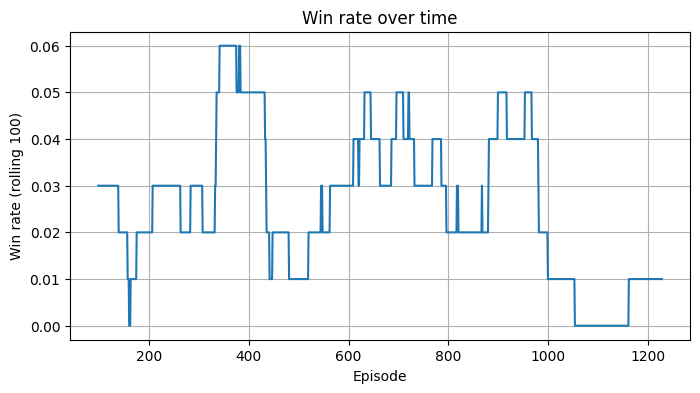

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Plot learning
df = pd.read_csv("monitor.csv", skiprows=1)
df['win'] = (df['win'] > 0).astype(int)

window = 100
df['win_rate'] = df['win'].rolling(window).mean()

plt.figure(figsize=(8,4))
plt.plot(df['win_rate'])
plt.xlabel('Episode')
plt.ylabel(f'Win rate (rolling {window})')
plt.title('Win rate over time')
plt.grid(True)
plt.show()


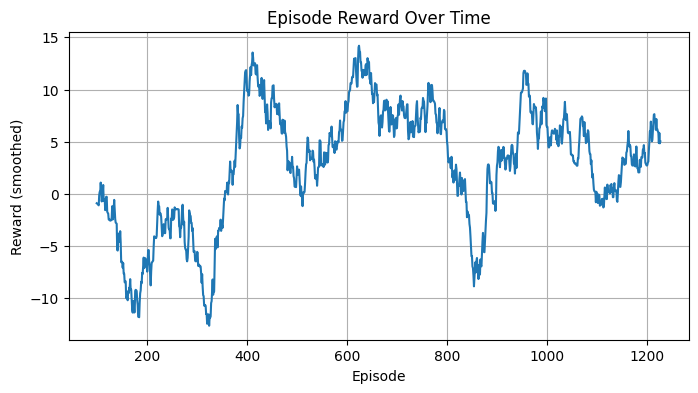

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Plotting reward
df["reward_smooth"] = df["r"].rolling(100).mean()

plt.figure(figsize=(8,4))
plt.plot(df["reward_smooth"])
plt.xlabel("Episode")
plt.ylabel("Reward (smoothed)")
plt.title("Episode Reward Over Time")
plt.grid(True)
plt.show()

In [ ]:
from game import bot_trials

real_env = env.envs[0].env
def model_decision(grid: list[list[str]], valid_moves: list[str]) -> str:
    obs = real_env._get_observation(grid)
    obs = obs.reshape(1, -1)   # SB3 expects batch dimension

    action, _ = model.predict(obs, deterministic=True)

    return real_env.action_map[int(action)]


model.set_parameters(model.get_parameters())  # removes training-only buffers
bot_trials(6, 7, 1000, model_decision)

/tmp/ipython-input-3242147357.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return real_env.action_map[int(action)]


KeyboardInterrupt: 

In [ ]:
model.save("ppo_sixseven2")

# A2C model

In [ ]:
from stable_baselines3 import A2C
policy_kwargs = dict(net_arch=[128, 128, 64])
model = A2C("MlpPolicy", env, verbose=1, policy_kwargs=policy_kwargs)

Using cuda device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run A2C on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [ ]:
model.learn(total_timesteps=5_000)

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 63.1     |
|    ep_rew_mean        | -35.8    |
| time/                 |          |
|    fps                | 184      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.16    |
|    explained_variance | 0.267    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 2.79     |
|    value_loss         | 3.06     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 80.5     |
|    ep_rew_mean        | -22.6    |
| time/                 |          |
|    fps                | 246      |
|    iterations         | 200      |
|    time_elapsed       | 4        |
|    total_timesteps    | 1000     |
| train/                |          |
|

KeyboardInterrupt: 

In [ ]:
from game import bot_trials

def model_decision(grid: list[list[str]], valid_moves: list[str]) -> str:
    action, _states = model.predict(env._get_observation(grid), deterministic=True)
    return env.action_map[int(action)]

bot_trials(6, 7, 1000, model_decision)

Wins: 1, Losses: 999, Average number of moves: 983.263, Total win moves: 7


In [ ]:
# save model
model.save("a2c_sixseven2")

# QRDQN

In [3]:
!pip install sb3_contrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 2.4 MB/s eta 0:00:0000:01


In [ ]:
import optuna
from stable_baselines3 import DQN
from sb3_contrib import QRDQN
from stable_baselines3.common.evaluation import evaluate_policy

optuna.logging.set_verbosity(optuna.logging.WARNING)

def optimize_dqn(trial):
    env = DummyVecEnv([lambda: Monitor(SixSevenEnv())])

    # --- Suggest hyperparameters ---
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.90, 0.999)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    buffer_size = trial.suggest_categorical("buffer_size", [50000, 100000, 200000])
    tau = trial.suggest_float("tau", 0.90, 1.0)
    exploration_final_eps = trial.suggest_float("exploration_final_eps", 0.01, 0.1)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0.1, 0.5)
    target_update_interval = trial.suggest_categorical("target_update_interval", [250, 500, 1000])

    # --- Create model ---
    model = QRDQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=batch_size,
        buffer_size=buffer_size,
        tau=tau,
        exploration_final_eps=exploration_final_eps,
        exploration_fraction=exploration_fraction,
        target_update_interval=target_update_interval,
        learning_starts=2000,
        verbose=0,
    )

    # --- Train briefly (Optuna trials should be short!) ---
    for step in range(10):
        model.learn(1000, reset_num_timesteps=False)

        # Get recent rewards from ep_info_buffer
        if len(model.ep_info_buffer) > 0:
            mean_reward = sum([ep["r"] for ep in model.ep_info_buffer]) / len(model.ep_info_buffer)
        else:
            mean_reward = -9999

        # Report intermediate result
        trial.report(mean_reward, step)

        # Early stopping if trial is bad
        if trial.should_prune():
            raise optuna.TrialPruned()

    return mean_reward

/home/johnl/ProjectProgram/training/rlvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1000)
study = optuna.create_study(direction="maximize", pruner=pruner)

study.optimize(optimize_dqn, n_trials=20)

/tmp/ipykernel_5592/81650713.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
/tmp/ipykernel_5592/81650713.py:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 0.90, 0.999)
/tmp/ipykernel_5592/81650713.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  tau = trial.suggest_uniform("tau", 0.90, 1.0)
/tmp/ipykernel_5592/81650713.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. S

In [6]:
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value: -143.00477777777778
  Params: 
    learning_rate: 0.0009600441374087953
    gamma: 0.9491850305634247
    batch_size: 64
    buffer_size: 200000
    tau: 0.9694769454244737
    exploration_final_eps: 0.09821245889020119
    exploration_fraction: 0.24231142711971349
    target_update_interval: 500


In [7]:
best_params = study.best_params

# model = DQN(
model = QRDQN(
    "MlpPolicy",
    env,
    **best_params,
    verbose=1
)


Using cpu device


In [19]:
%%capture --no-display
model.learn(total_timesteps=100_000)

In [24]:
model.learn(total_timesteps=100_000, reset_num_timesteps=False)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.1     |
|    ep_rew_mean      | -75.4    |
|    exploration_rate | 0.0982   |
| time/               |          |
|    episodes         | 1100     |
|    fps              | 137      |
|    time_elapsed     | 1        |
|    total_timesteps  | 100247   |
| train/              |          |
|    learning_rate    | 0.00096  |
|    loss             | 698      |
|    n_updates        | 74986    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 98.6     |
|    ep_rew_mean      | -75.3    |
|    exploration_rate | 0.0982   |
| time/               |          |
|    episodes         | 1104     |
|    fps              | 122      |
|    time_elapsed     | 4        |
|    total_timesteps  | 100550   |
| train/              |          |
|    learning_rate    | 0.00096  |
|    loss             | 618      |
|    n_updates      

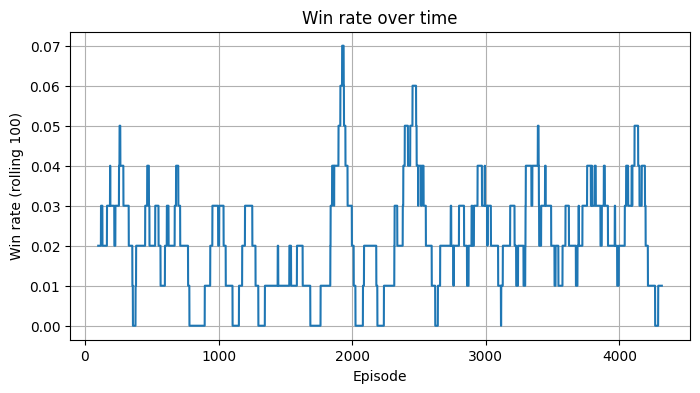

In [25]:
# Plot learning
df = pd.read_csv("monitor.csv", skiprows=1)
df['win'] = (df['win'] > 0).astype(int)

window = 100
df['win_rate'] = df['win'].rolling(window).mean()

plt.figure(figsize=(8,4))
plt.plot(df['win_rate'])
plt.xlabel('Episode')
plt.ylabel(f'Win rate (rolling {window})')
plt.title('Win rate over time')
plt.grid(True)
plt.show()


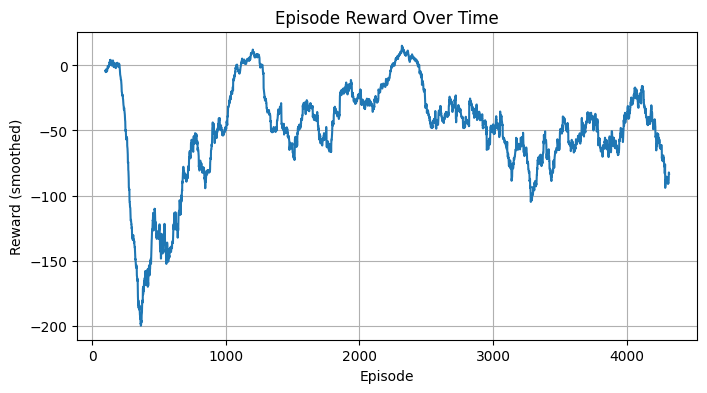

In [26]:
# Plotting reward
df["reward_smooth"] = df["r"].rolling(100).mean()

plt.figure(figsize=(8,4))
plt.plot(df["reward_smooth"])
plt.xlabel("Episode")
plt.ylabel("Reward (smoothed)")
plt.title("Episode Reward Over Time")
plt.grid(True)
plt.show()

In [27]:
from game import bot_trials

real_env = env.envs[0].env
def model_decision(grid: list[list[str]], valid_moves: list[str]) -> str:
    obs = real_env._get_observation(grid)
    obs = obs.reshape(1, -1)   # SB3 expects batch dimension

    action, _ = model.predict(obs, deterministic=True)

    return real_env.action_map[int(action)]


model.set_parameters(model.get_parameters())  # removes training-only buffers
bot_trials(6, 7, 1000, model_decision)

/tmp/ipykernel_5592/3242147357.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return real_env.action_map[int(action)]


Wins: 18, Losses: 982, Average number of moves: 264.667, Total win moves: 1021


In [28]:
model.save("models/qrdqn_sixseven3")

In [ ]:
model.load("dqn_sixseven")